# Durée de vie de batteries

Avec l'essort de l'informatique, les batteries sont devenues d'une importance capitale. Cependant, il devient très intéressant de déterminer combien de temps de bon fonctionnement il reste à une batterie. Pour répondre à cette question, nous contruirons un modèle permettant de prédire le nombre de cycle encore disponible pour la batterie. Nous entrainerons ce modèle sur la base de donnée Battery_RUL.csv, que notre client nous a fourni.

Cette base de donnée a été construite à partir de l'étude sur le cycle de vie de 14 batteries de même type.


## Table des matières :
- [Exploration et prétraitement des données](#Exploration-et-prétraitement-des-données)
- [Visualisation des données](#Visualisation-des-données)
- [Prétraitement des données](#Prétraitement-des-données)
- [Recherche du meilleur modèle](#Recherche-du-meilleur-modèle)
- [Optimisation des hyperparamètres](#Optimisation-des-hyperparamètres)
- [Visualisation des données explicatives](#Visualisation-des-données-explicatives)
- [Synthèse et recommandations](#Synthèse-et-recommandations)
- [Prise de recul](#Prise-de-recul)

## Exploration et prétraitement des données

La base de donnée comprend plusieurs variables : 
- F0 : Cycle_Index --> flottant
- F1 : Discharge Time (s) --> flottant
- F2 : Decrement 3.6-3.4V (s) --> flottant
- F3 : Max. Voltage Dischar. (V) --> flottant
- F4 : Min. Voltage Charg. (V) --> flottant
- F5 : Time at 4.15V (s) --> flottant
- F6 : Time constant current (s) --> flottant
- F7 : Charging time (s) --> flottant
- RUL --> entier (cible)

Nous allons retirer la variable F0 (Cycle_Index) de la base de données, car on ne connait généralement pas le nombre de cycle qu'a eu une batterie au moment où on souhaite connaitre sa RUL.

L'objectif est d'utiliser uniquement la tension, le courant et le temps comme données d'entrée. Cependant, utiliser ces variables directement comme données d'entrée est impossible, car elles fournissent des informations dénuées de sens et ne suffisent pas à créer un modèle. Par conséquent, elles doivent être traitées et manipulées comme base pour développer de nouvelles fonctionnalités avec lesquelles le modèle s'entraînera.

Les variables utilisées sont expliquées par ces graphiques.

<img src=Battery_RUL_exp.png>

In [1]:
# import des bibliothèques requises
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score

In [2]:
# récupération de la base de donnée
df = pd.read_csv('Battery_RUL.csv').drop(columns="Cycle_Index") # on enlève le nombre de cycle qu'ont connu les batteries

# affichage des premières lignes de la bd
df.head()

,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107


In [3]:
# on vérifie qu'il ne manque aucune valeur
print(df.isnull().sum())

Discharge Time (s)           0
Decrement 3.6-3.4V (s)       0
Max. Voltage Dischar. (V)    0
Min. Voltage Charg. (V)      0
Time at 4.15V (s)            0
Time constant current (s)    0
Charging time (s)            0
RUL                          0
dtype: int64


## Visualisation des données

In [4]:
# on affiche les informations générales sur les données
df.describe()

,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
count,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000
mean,4581.273960,1239.784672,3.908176,3.577904,3768.336171,5461.266970,10066.496204,554.194172
std,33144.012077,15039.589269,0.091003,0.123695,9129.552477,25155.845202,26415.354121,322.434514
min,8.690000,-397645.908000,3.043000,3.022000,-113.584000,5.980000,5.980000,0.000000
25%,1169.310000,319.600000,3.846000,3.488000,1828.884179,2564.310000,7841.922500,277.000000
50%,1557.250000,439.239471,3.906000,3.574000,2930.203500,3824.260000,8320.415000,551.000000
75%,1908.000000,600.000000,3.972000,3.663000,4088.326500,5012.350000,8763.282500,839.000000
max,958320.370000,406703.768000,4.363000,4.379000,245101.117000,880728.100000,880728.100000,1133.000000


C:\Users\tombe\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


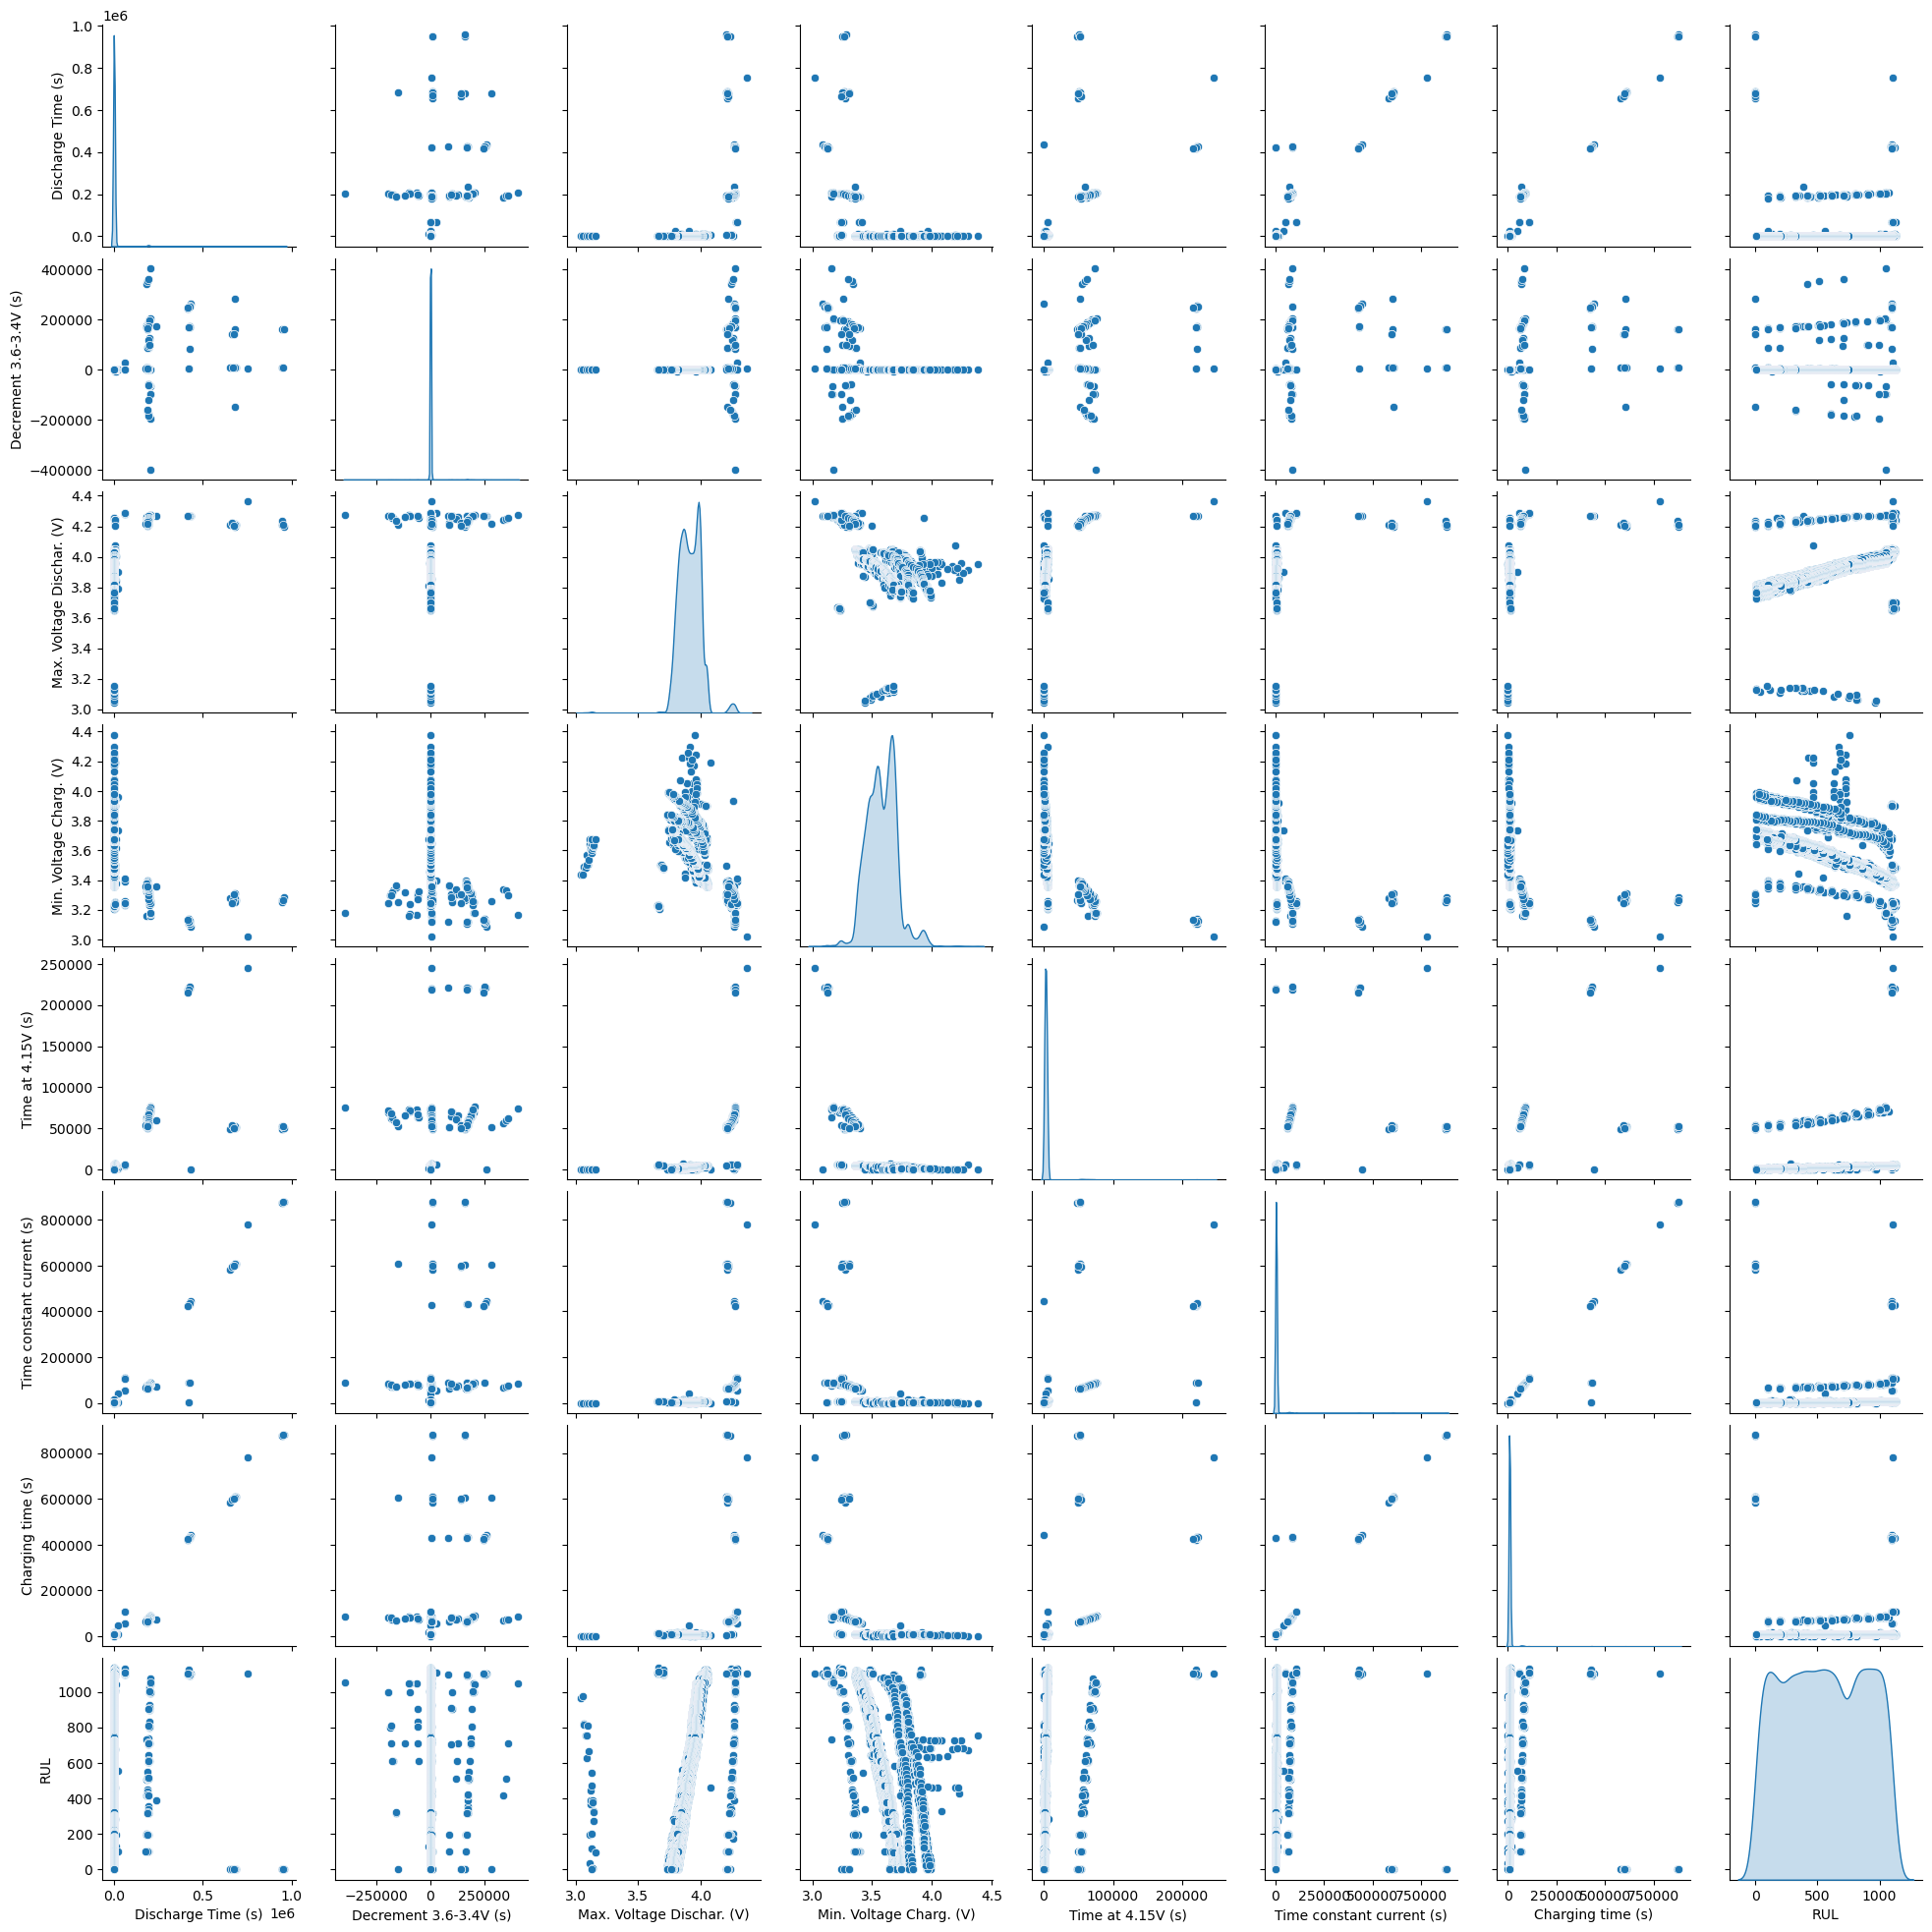

In [5]:
# affichage des correlations entre variables quantitatives (pair-plots)

sns.pairplot(df, diag_kind="kde")
plt.show()

Nous pouvon remarquer d'ores et déjà que des corrélations sont présentes. Par exemple, nous pouvons voir que le temps de chargement, de déchargement et de tension constante sont positivement corélées entre elles.

Nous pouvons également oberver le trajet des différentes piles pour la RUL : au long d'un cycle de vie, les batteries gardent a peu près les mêmes propriétés. Celle-ci diffèrent légèrement entre elles. Cela rend les données que l'on possède non indépendantes entre elles : les données d'une même batterie sont dépendantes de celle-ci. Essayons de construire un modèle prédictif avec cette particularité.

## Prétraitement des données

In [6]:
# nous allons normaliser les données avant d'utiliser la méthode d'analyse en composante principale (ACP)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# séparation des données cibles
X_pd = df.drop('RUL', axis=1)  
y_pd = df['RUL'] 

X_source, y = X_pd.to_numpy(), y_pd.to_numpy()

# normalisation des données
scaler = StandardScaler()
X = scaler.fit_transform(X_source)

,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s)
PC1,0.474029,0.271555,0.272123,-0.225107,0.418270,0.441232,0.455187
PC2,0.194097,0.077076,-0.621060,0.670320,-0.030944,0.236080,0.254265
PC3,-0.113630,0.895549,-0.038386,0.094548,0.185925,-0.292521,-0.233518
PC4,0.062095,-0.341892,0.026498,0.263284,0.809108,-0.370968,-0.130231
PC5,0.023328,0.021133,0.730453,0.647269,-0.201658,0.068189,-0.034283


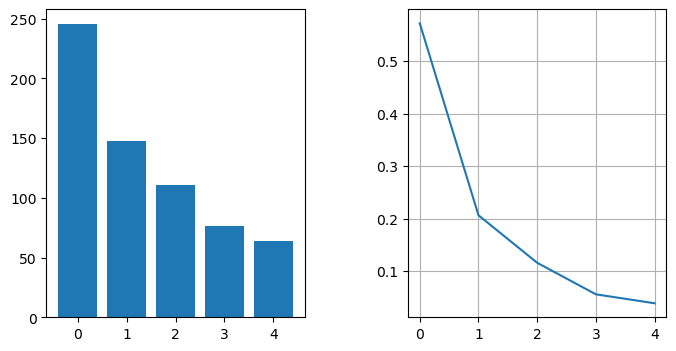

In [7]:
from sklearn.decomposition import PCA

# application de la PCA, de manière à conserver 95% de la variance
pca = PCA(n_components=0.95) 
pca.fit(X)  

## analyse des valeurs propres
# graphique de la part de la variance expliquée par chaque variable
plt.figure(facecolor='white', figsize=[8,4])
plt.subplot(1,2,1)
plt.bar(np.arange(pca.singular_values_.shape[0]), pca.singular_values_)
plt.subplot(1,2,2)
plt.plot(pca.explained_variance_ratio_)
plt.grid()
plt.gcf().subplots_adjust(wspace = 0.4)
# valeurs en brut
pd.DataFrame(pca.components_, columns=X_pd.columns, index=[f"PC{i+1}" for i in range(pca.n_components_)])

Nous pouvons ainsi réduire le problème à une étdue de 5 dimensions au lieu de 7. 

## Recherche du meilleur modèle

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# on divise les données pour l'apprentissage et les tests
# (80% pour l'entraînement et 20% pour le test)
X_app, X_test, y_app, y_test = train_test_split(X, y, test_size=0.2)

# on créé une liste des modèles à comparer (avec pipelines pour normaliser et réduire les données)
# on ne fera pas de pretraitement des doonnées pour les méthodes basées sur les arbres de décision,
# tels que Random Forest, Gradient Boosting ou XGBoost car ils sont insensibles à la corrélation ou la forme des variables
modeles = {
    "RL sans pca": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),      
    "Regression linéaire": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("model", LinearRegression())
    ]),
    "Regression Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("model", Ridge())
    ]),
    "Regression Lasso": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("model", Lasso())
    ]),
    "Random Forest": Pipeline([
        ("model", RandomForestRegressor(n_estimators=100))
    ]),
    "Gradient Boosting": Pipeline([
        ("model", GradientBoostingRegressor(n_estimators=100))
    ]),
    "XGBoost" : Pipeline([
        ("model", XGBRegressor(objective='reg:squarederror'))
    ]),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("model", KNeighborsRegressor())
    ]),
    "SVR": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("model", SVR())
    ])
}

# on fait l'évaluation avec validation croisée
model_names = []
mean_scores = []
std_scores = []

for name, modele in modeles.items():
    scores = cross_val_score(modele, X_app, y_app, scoring='neg_root_mean_squared_error', cv=5)
    rmse_scores = -scores
    model_names.append(name)
    mean_scores.append(rmse_scores.mean())
    std_scores.append(rmse_scores.std())
    print(f"RMSE {name} : {rmse_scores.mean()} +- {rmse_scores.std()}")


RMSE RL sans pca : 148.52267704260902 +- 8.081452913427732
RMSE Regression linéaire : 160.27739650698894 +- 5.762798901292525
RMSE Regression Ridge : 160.277460327887 +- 5.762171569504395
RMSE Regression Lasso : 160.33208079092418 +- 5.665047020886503
RMSE Random Forest : 24.67588677098925 +- 3.9123758915427542
RMSE Gradient Boosting : 44.91823024156395 +- 1.5801521297708623
RMSE XGBoost : 25.99547233581543 +- 2.6323805226979875
RMSE KNN : 43.298399562587534 +- 5.241402426528513
RMSE SVR : 118.57229475733342 +- 10.770081453613177


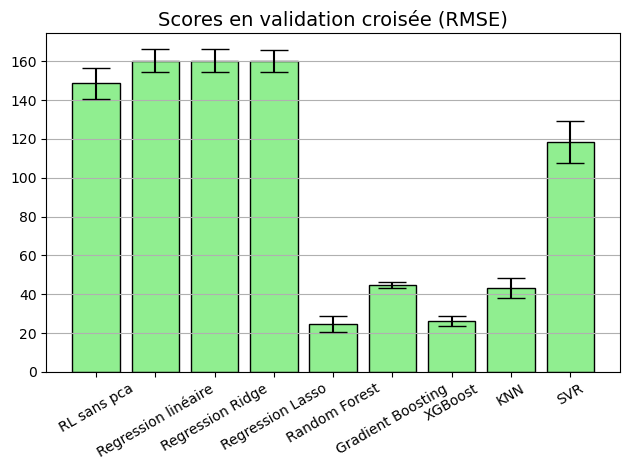

In [9]:
# affichage des résultats cross-validation sous forme de graphiques

plt.bar(model_names, mean_scores, yerr=std_scores, capsize=10, color='lightgreen', edgecolor='black')
plt.grid(axis='y')

plt.title("Scores en validation croisée (RMSE)", fontsize=14)
plt.gcf().set_facecolor('white')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Nous nous attendions à ce que la regression linéaire sans pca soit légèrement plus efficace car l'entrainement se fait sur la totalité des données. Cependant, nous avons pu observer pendant les tests que sa performance varie beaucoup, avec quelques fois un ecart type très grand, et quelques fois relativement faible. 

Nous pouvons voir que les modèles les plus performants sont les modèes ensemblistes (Random Forest, gradient boosting et XGBoost). Nous allons donc chercher à optimiser ces modèles en cherchant les meilleurs hyper-paramètres.

## Optimisation des hyperparamètres

Nous cherchons maintenant à optimiser les modèles séléctionné précédemment. Pour cela, nous allons utiliser Optuna.

In [10]:
## /!\ l'execution de cette partie dure plusieurs minutes, les resultats de cette partie sont résumés par 
## la capture d'écran du bloc de texte en dessous

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import optuna

def objective_RandomForest(trial):

    n_estimators = trial.suggest_int("n_estimators", 2, 20)
    max_depth = int(trial.suggest_float("max_depth", 1, 32, log=True))

    clf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)

    return cross_val_score(
        clf, X_app, y_app, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=3
    ).mean()

def objective_GradientBoosting(trial):

    n_estimators = trial.suggest_int("n_estimators", 2, 20)
    max_depth = int(trial.suggest_float("max_depth", 1, 32, log=True))
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)

    clf = GradientBoostingRegressor(n_estimators=n_estimators, 
                                    max_depth=max_depth, 
                                    learning_rate=learning_rate)

    return cross_val_score(
        clf, X_app, y_app, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=3
    ).mean()

def objective_XGBRegressor(trial):

    n_estimators = trial.suggest_int("n_estimators", 2, 20)
    max_depth = int(trial.suggest_float("max_depth", 1, 32, log=True))
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    gamma = trial.suggest_float("gamma", 0.0001, 10, log=True)

    clf = XGBRegressor(n_estimators=n_estimators, 
                        max_depth=max_depth, 
                        learning_rate=learning_rate,
                        gamma=gamma)

    return cross_val_score(
        clf, X_app, y_app, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=3
    ).mean()


# random forest
study_RandomForest = optuna.create_study(direction="maximize")
study_RandomForest.optimize(objective_RandomForest, n_trials=100)

trial_RandomForest = study_RandomForest.best_trial

# gradient boosting
study_GradientBoosting = optuna.create_study(direction="maximize")
study_GradientBoosting.optimize(objective_GradientBoosting, n_trials=100)

trial_GradientBoosting = study_GradientBoosting.best_trial

# xgb
study_XGBRegressor = optuna.create_study(direction="maximize")
study_XGBRegressor.optimize(objective_XGBRegressor, n_trials=100)

trial_XGBRegressor = study_XGBRegressor.best_trial

[I 2025-04-12 18:46:13,513] A new study created in memory with name: no-name-5e77286b-ac85-4f9b-85f7-6ef07c10830c
[I 2025-04-12 18:46:17,982] Trial 0 finished with value: -101.39927318505302 and parameters: {'n_estimators': 6, 'max_depth': 2.825130869714392}. Best is trial 0 with value: -101.39927318505302.
[I 2025-04-12 18:46:20,849] Trial 1 finished with value: -57.187972733800336 and parameters: {'n_estimators': 20, 'max_depth': 4.248779871434853}. Best is trial 1 with value: -57.187972733800336.
[I 2025-04-12 18:46:24,455] Trial 2 finished with value: -26.281860629833744 and parameters: {'n_estimators': 13, 'max_depth': 23.347251287605868}. Best is trial 2 with value: -26.281860629833744.
[I 2025-04-12 18:46:25,060] Trial 3 finished with value: -49.516145023419575 and parameters: {'n_estimators': 19, 'max_depth': 5.980066926391869}. Best is trial 2 with value: -26.281860629833744.
[I 2025-04-12 18:46:25,175] Trial 4 finished with value: -52.5950023953784 and parameters: {'n_estimat

[I 2025-04-12 18:46:57,869] Trial 41 finished with value: -27.919270612866132 and parameters: {'n_estimators': 19, 'max_depth': 11.54627270316176}. Best is trial 35 with value: -25.105305866154833.
[I 2025-04-12 18:46:59,278] Trial 42 finished with value: -25.2220655939349 and parameters: {'n_estimators': 16, 'max_depth': 22.316546364751154}. Best is trial 35 with value: -25.105305866154833.
[I 2025-04-12 18:47:00,700] Trial 43 finished with value: -25.24336355016911 and parameters: {'n_estimators': 18, 'max_depth': 21.75666030485068}. Best is trial 35 with value: -25.105305866154833.
[I 2025-04-12 18:47:01,830] Trial 44 finished with value: -25.32922791390742 and parameters: {'n_estimators': 16, 'max_depth': 21.4760607545361}. Best is trial 35 with value: -25.105305866154833.
[I 2025-04-12 18:47:02,007] Trial 45 finished with value: -165.03072006410648 and parameters: {'n_estimators': 18, 'max_depth': 1.4295038330349934}. Best is trial 35 with value: -25.105305866154833.
[I 2025-04-12

[I 2025-04-12 18:47:53,046] Trial 83 finished with value: -25.908707254283616 and parameters: {'n_estimators': 20, 'max_depth': 14.571622818036142}. Best is trial 77 with value: -24.91493741472695.
[I 2025-04-12 18:47:53,740] Trial 84 finished with value: -34.561470964188764 and parameters: {'n_estimators': 18, 'max_depth': 8.89131730955036}. Best is trial 77 with value: -24.91493741472695.
[I 2025-04-12 18:47:55,187] Trial 85 finished with value: -25.390401918272385 and parameters: {'n_estimators': 19, 'max_depth': 19.478813244129462}. Best is trial 77 with value: -24.91493741472695.
[I 2025-04-12 18:47:55,971] Trial 86 finished with value: -43.36230549334249 and parameters: {'n_estimators': 17, 'max_depth': 6.301410129972071}. Best is trial 77 with value: -24.91493741472695.
[I 2025-04-12 18:47:57,715] Trial 87 finished with value: -25.26478723688616 and parameters: {'n_estimators': 18, 'max_depth': 22.930670201842407}. Best is trial 77 with value: -24.91493741472695.
[I 2025-04-12 1

[I 2025-04-12 18:48:45,431] Trial 21 finished with value: -39.41946113281971 and parameters: {'n_estimators': 18, 'max_depth': 10.392487048798772, 'learning_rate': 0.1267051806387462}. Best is trial 14 with value: -26.60560112901045.
[I 2025-04-12 18:48:48,121] Trial 22 finished with value: -45.200332507673714 and parameters: {'n_estimators': 18, 'max_depth': 18.331963067170292, 'learning_rate': 0.11866866102915989}. Best is trial 14 with value: -26.60560112901045.
[I 2025-04-12 18:48:49,315] Trial 23 finished with value: -31.795514219827552 and parameters: {'n_estimators': 20, 'max_depth': 7.511361081163062, 'learning_rate': 0.18986404820250177}. Best is trial 14 with value: -26.60560112901045.
[I 2025-04-12 18:48:50,946] Trial 24 finished with value: -29.032191031692363 and parameters: {'n_estimators': 20, 'max_depth': 8.119562661206906, 'learning_rate': 0.19463403532060944}. Best is trial 14 with value: -26.60560112901045.
[I 2025-04-12 18:48:53,990] Trial 25 finished with value: -1

[I 2025-04-12 18:49:55,190] Trial 56 finished with value: -27.27016950320412 and parameters: {'n_estimators': 20, 'max_depth': 12.123042429700602, 'learning_rate': 0.17335696156744723}. Best is trial 14 with value: -26.60560112901045.
[I 2025-04-12 18:49:55,675] Trial 57 finished with value: -212.80341346049195 and parameters: {'n_estimators': 3, 'max_depth': 12.315427079947552, 'learning_rate': 0.1298067830859938}. Best is trial 14 with value: -26.60560112901045.
[I 2025-04-12 18:49:58,338] Trial 58 finished with value: -54.365027970413 and parameters: {'n_estimators': 19, 'max_depth': 11.16489617855153, 'learning_rate': 0.09586821843600564}. Best is trial 14 with value: -26.60560112901045.
[I 2025-04-12 18:50:00,578] Trial 59 finished with value: -63.01105067793238 and parameters: {'n_estimators': 11, 'max_depth': 17.375068333388537, 'learning_rate': 0.14719479203995825}. Best is trial 14 with value: -26.60560112901045.
[I 2025-04-12 18:50:04,236] Trial 60 finished with value: -176.4

[I 2025-04-12 18:51:09,105] Trial 91 finished with value: -29.23288029575832 and parameters: {'n_estimators': 20, 'max_depth': 8.80834508505282, 'learning_rate': 0.18418698149319365}. Best is trial 72 with value: -26.31569705907101.
[I 2025-04-12 18:51:10,247] Trial 92 finished with value: -35.6233264405578 and parameters: {'n_estimators': 20, 'max_depth': 6.299843319569537, 'learning_rate': 0.18395343712543052}. Best is trial 72 with value: -26.31569705907101.
[I 2025-04-12 18:51:13,257] Trial 93 finished with value: -26.10875720787421 and parameters: {'n_estimators': 20, 'max_depth': 12.017160308327265, 'learning_rate': 0.19669698363586852}. Best is trial 93 with value: -26.10875720787421.
[I 2025-04-12 18:51:15,806] Trial 94 finished with value: -27.87946796061554 and parameters: {'n_estimators': 19, 'max_depth': 11.855744100767724, 'learning_rate': 0.16905579134419688}. Best is trial 93 with value: -26.10875720787421.
[I 2025-04-12 18:51:17,901] Trial 95 finished with value: -28.51

[I 2025-04-12 18:51:48,436] Trial 23 finished with value: -26.877883911132812 and parameters: {'n_estimators': 15, 'max_depth': 11.01418576746096, 'learning_rate': 0.2855954275171724, 'gamma': 0.002851234558426073}. Best is trial 23 with value: -26.877883911132812.
[I 2025-04-12 18:51:49,116] Trial 24 finished with value: -37.245104471842446 and parameters: {'n_estimators': 15, 'max_depth': 11.168329777556133, 'learning_rate': 0.16169767752411215, 'gamma': 0.003078013029550175}. Best is trial 23 with value: -26.877883911132812.
[I 2025-04-12 18:51:49,368] Trial 25 finished with value: -34.383307139078774 and parameters: {'n_estimators': 12, 'max_depth': 8.636606774833046, 'learning_rate': 0.23022130186724124, 'gamma': 0.00039447620306689023}. Best is trial 23 with value: -26.877883911132812.
[I 2025-04-12 18:51:49,510] Trial 26 finished with value: -61.70237604777018 and parameters: {'n_estimators': 20, 'max_depth': 4.743861794869434, 'learning_rate': 0.10140093024256852, 'gamma': 0.00

[I 2025-04-12 18:53:23,088] Trial 54 finished with value: -25.1573543548584 and parameters: {'n_estimators': 18, 'max_depth': 25.981605361474323, 'learning_rate': 0.2971118650057801, 'gamma': 0.00022343285674752232}. Best is trial 53 with value: -24.967422485351562.
[I 2025-04-12 18:53:24,083] Trial 55 finished with value: -196.26203409830728 and parameters: {'n_estimators': 16, 'max_depth': 31.95521557170597, 'learning_rate': 0.03135879046692815, 'gamma': 0.00015257864609644897}. Best is trial 53 with value: -24.967422485351562.
[I 2025-04-12 18:53:28,545] Trial 56 finished with value: -30.01133664449056 and parameters: {'n_estimators': 18, 'max_depth': 27.06388518147405, 'learning_rate': 0.16357955969813762, 'gamma': 0.00021672147970578441}. Best is trial 53 with value: -24.967422485351562.
[I 2025-04-12 18:53:38,731] Trial 57 finished with value: -25.08903630574544 and parameters: {'n_estimators': 18, 'max_depth': 26.88620762679836, 'learning_rate': 0.29430452169807025, 'gamma': 0.0

[I 2025-04-12 18:55:44,709] Trial 85 finished with value: -57.048075358072914 and parameters: {'n_estimators': 20, 'max_depth': 2.734439221127528, 'learning_rate': 0.2647283766332858, 'gamma': 0.00012318653896915198}. Best is trial 83 with value: -24.94001070658366.
[I 2025-04-12 18:55:49,469] Trial 86 finished with value: -26.147496541341145 and parameters: {'n_estimators': 19, 'max_depth': 21.375310297224818, 'learning_rate': 0.21087956980559122, 'gamma': 0.00017840419942383528}. Best is trial 83 with value: -24.94001070658366.
[I 2025-04-12 18:55:50,579] Trial 87 finished with value: -26.087289174397785 and parameters: {'n_estimators': 18, 'max_depth': 12.408092287253474, 'learning_rate': 0.23864563108612635, 'gamma': 0.0023524488495816637}. Best is trial 83 with value: -24.94001070658366.
[I 2025-04-12 18:55:51,782] Trial 88 finished with value: -164.9356486002604 and parameters: {'n_estimators': 18, 'max_depth': 19.890147711189186, 'learning_rate': 0.03774687477923528, 'gamma': 0.

RandomForest (RMSE): 24.91493741472695
Best hyperparameters: {'n_estimators': 20, 'max_depth': 16.986256939502518}
GradientBoosting (RMSE): 26.10875720787421
Best hyperparameters: {'n_estimators': 20, 'max_depth': 12.017160308327265, 'learning_rate': 0.19669698363586852}
XBG (RMSE): 24.94001070658366
Best hyperparameters: {'n_estimators': 18, 'max_depth': 22.43050074215266, 'learning_rate': 0.29620871969903906, 'gamma': 0.00013495902987476147}


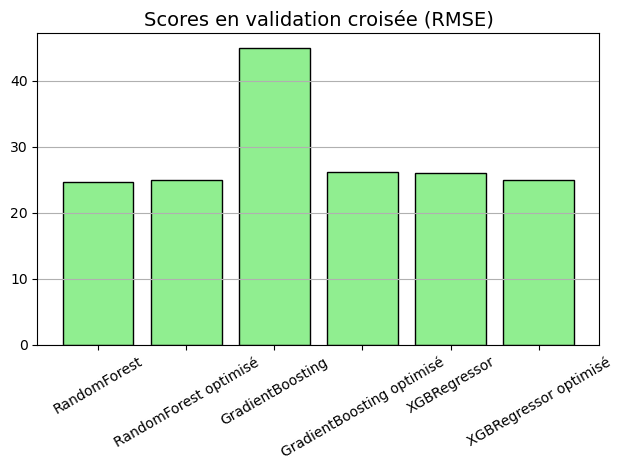

In [16]:
## bloc à ne pas lancer si le bloc précédent ne l'a pas été

model_names = ["RandomForest", "RandomForest optimisé",
               "GradientBoosting", "GradientBoosting optimisé", 
               "XGBRegressor", "XGBRegressor optimisé"]
scores = []

print("RandomForest (RMSE): {}".format( - trial_RandomForest.value))
scores.append(mean_scores[4])
scores.append(- trial_RandomForest.value)
print("Best hyperparameters: {}".format(trial_RandomForest.params))

print("GradientBoosting (RMSE): {}".format( - trial_GradientBoosting.value))
scores.append(mean_scores[5])
scores.append(- trial_GradientBoosting.value)
print("Best hyperparameters: {}".format(trial_GradientBoosting.params))

print("XBG (RMSE): {}".format( - trial_XGBRegressor.value))
scores.append(mean_scores[6])
scores.append(- trial_XGBRegressor.value)
print("Best hyperparameters: {}".format(trial_XGBRegressor.params))

# affichage des résultats cross-validation sous forme de graphiques

plt.bar(model_names, scores, capsize=10, color='lightgreen', edgecolor='black')
plt.grid(axis='y')

plt.title("Scores en validation croisée (RMSE)", fontsize=14)
plt.gcf().set_facecolor('white')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

#### Voici les résultats d'optuna obtenus durant la phase de développement du notebook :

<img src=batterie_optuna.png>

On s'attendait à ce que l'optimisation améliore les performance pour tous les modèles, car les paramètres utiliés par défaut ne sont pas forcément les meilleurs. Or nous n'observons qu'une amélioration pour le gradient boosting. L'optimisation des paramètres n'est pas significativement intéressante dans ce cas d'étude.

In [12]:
from sklearn.metrics import mean_squared_error

best_model1 = RandomForestRegressor(n_estimators = 20, max_depth = 23)
best_model2 = GradientBoostingRegressor(n_estimators = 19, max_depth = 11, learning_rate = 0.1931)
best_model3 = XGBRegressor(n_estimators = 20, max_depth = 25, learning_rate = 0.23336435890031862, gamma = 0.179)

best_model1.fit(X_app, y_app)
best_model2.fit(X_app, y_app)
best_model3.fit(X_app, y_app)

y_pred1 = best_model1.predict(X_test)
y_pred2 = best_model2.predict(X_test)
y_pred3 = best_model3.predict(X_test)

score_test = [mean_squared_error(y_test, y_pred1), 
              mean_squared_error(y_test, y_pred2), 
              mean_squared_error(y_test, y_pred3)]

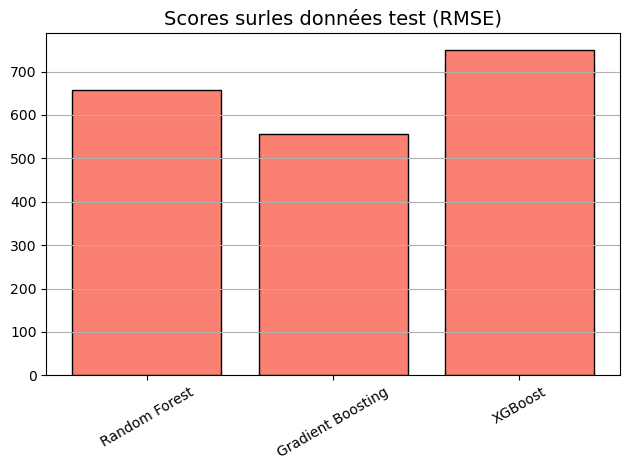

In [13]:
# affichage des résultats cross-validation sous forme de graphiques
model_names = ["Random Forest", "Gradient Boosting", "XGBoost"]
plt.bar(model_names, score_test, capsize=10, color='salmon', edgecolor='black')
plt.grid(axis='y')

plt.title("Scores sur les données test (RMSE)", fontsize=14)
plt.gcf().set_facecolor('white')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

On s'attendait à de meilleures performances en raison de la quantité de donnée d'entrainement par rapport aux données test. Cependant, nous pourrions expliquer ces résultats par le fait que les variables ne sont pas entièrement indépendantes, et que les données sont tirées de 14 piles seulement. 

Il n'est surement pas impossible qu'il y ait eu de l'overfitting.

## Visualisation des données explicatives

Essayons de voir l'impact des différentes variables sur les modèles séléctionnés.

In [14]:
# regardons quelles variables impactent le plus le modèle
from sklearn.inspection import permutation_importance

result1 = permutation_importance(best_model1, X_test, y_test, n_repeats=10)
result2 = permutation_importance(best_model2, X_test, y_test, n_repeats=10)
result3 = permutation_importance(best_model3, X_test, y_test, n_repeats=10)


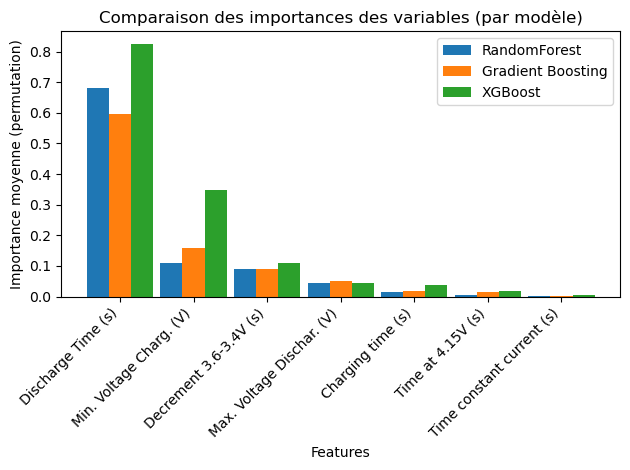

In [15]:
# affichage 
feat_perm1 = pd.DataFrame({
    'Feature': X_pd.columns,
    'Importance': result1.importances_mean
}).sort_values(by='Importance', ascending=False)
feat_perm2 = pd.DataFrame({
    'Feature': X_pd.columns,
    'Importance': result2.importances_mean
}).sort_values(by='Importance', ascending=False)
feat_perm3 = pd.DataFrame({
    'Feature': X_pd.columns,
    'Importance': result3.importances_mean
}).sort_values(by='Importance', ascending=False)

n = np.arange(len(feat_perm1['Feature']))
# un ajoute une barre pour chaque modèle
plt.bar(n, feat_perm1['Importance'], width=0.3, label="RandomForest")
plt.bar(n + 0.3, feat_perm2['Importance'], width=0.3, label="Gradient Boosting")
plt.bar(n + 0.6, feat_perm3['Importance'], width=0.3, label="XGBoost")

plt.xticks(n + 0.3, feat_perm1['Feature'], rotation=45, ha='right')
plt.xlabel("Features")
plt.ylabel("Importance moyenne (permutation)")
plt.title("Comparaison des importances des variables (par modèle)")
plt.legend()
plt.tight_layout()
plt.show()

Ainsi, la variable qui donne la meilleure indication sur la RUL de la batterie est son temps de charge, pour tous les modèles.

On remarque également que le XGBoost prend plus en compte les variables secondaires que les autres modèles. On peut donc supposer qu'il est plus polyvalent que les autres, et aura un meilleure score sur les données test.

## Synthèse et recommandations

En conclusion, d'après ce jeu de données, les variables qui expliquent le plus la durée de vie restante d'une batterie  sont :
- le temps de déchargement de la batterie
- le voltage de la batterie lorsqu'elle est à plat

Cette relation est à interpréter avec prudence étant donné que les performances obtenues sur les données tests ne sont pas très bonnes.

Le meilleur modèle que l'on puisse vous donner en tant que tel est un XGBRegressor, avec les paramètres suivants n_estimators = 20, max_depth = 25, learning_rate = 0.233, gamma = 0.179.

Pour entrainer un modèle plus efficace, il faudrait réaliser des mesures sur plus de batteries (environ une centaine serait suffisant). 


## Prise de recul

Pour réaliser cette étude, la principale difficulté a été d'identifier les bonnes chaines de traitement à créer pour chaque modèle. Les modèles basés sur des arbres de décisions n'ont pas les mêmes besoin de prétraitement de donnée.

Un autre point qui a ralentit l'étude à été de comprendre d'ou venaient les différentes variables.

Il aurait étét judicieux de continuer l'étude (notament sur les données test) avec les modèles de régression classiques (SVR, ElasticNet, régression logistique) pour voir si ces modèles étaient plus performants sur les données test, notamment à cause d'un potentiel overfitting. Nous avons décidé de séléctionner les modèles qui étaient le plus efficace en cross-validation, alors que ce n'est pas le meilleur critère pour valider un modèle.

Source de la bd : https://www.kaggle.com/datasets/ignaciovinuales/battery-remaining-useful-life-rul
